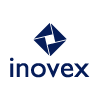


# Quantization aware training (QAT) of a MobileNet classifier


This notebook illustrates how you can use quantization aware trainig on a pre-trained MobileNetV2 model to create your own, lightweight neural network. 
This notebook is companion material to the blog post series *Deep Learning for mobile devices with TensorFlow Lite*.

In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

# Load Dataset

The following cell fetches the whole Dataset from TFDS and store it in the runtime. Note that the data will be lost if you lose your runtime. If you want to avoid this, consider connecting your Google drive with the runtime and store your dataset in a drive folder. 


We use the TFDS slicing API to reserve 80% of the original train split as actual training data and 20% as validation data to verify the training progress after each epoch. We want to see which features are provided by the generator, so we add the `with_info=True` argument to the function call.

This is going to run for a few minutes, so you can probably get you some coffee ;)

In [ ]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'cars196',
    split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=True
)

## What have we got from our Dataset?

Let's examine the content of the Dataset description that we downloaded alongside our copy of the dataset.

In [ ]:
metadata

Alright, so we have a total of 16185 images split roughly into a 50-50 train/test split. Each sample consists of a `BBoxFeature`, which contains normalized bounding box coordinates in the order [ymin, xmin, ymax, xmax], a numeric label and the image of the car. Lets plot some of the cars together with their bounding boxes. 

# Visualize samples and features

Unfortunately, the dataset provider only provides numerical labels. However, for visualization and especially when deploying our model, we want to display the exact make, model and year of the car instead of a cryptic number that nobody understands. I copied the following list with label names from the source code of the dataset provider. You can find the source code [on GitHub](https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/image_classification/cars196.py).

In [ ]:
CLASS_NAMES = [
    'AM General Hummer SUV 2000', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012',
    'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura Integra Type R 2001',
    'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012',
    'Aston Martin V8 Vantage Coupe 2012',
    'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012',
    'Audi RS 4 Convertible 2008', 'Audi A5 Coupe 2012', 'Audi TTS Coupe 2012',
    'Audi R8 Coupe 2012', 'Audi V8 Sedan 1994', 'Audi 100 Sedan 1994',
    'Audi 100 Wagon 1994', 'Audi TT Hatchback 2011', 'Audi S6 Sedan 2011',
    'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S4 Sedan 2012',
    'Audi S4 Sedan 2007', 'Audi TT RS Coupe 2012',
    'BMW ActiveHybrid 5 Sedan 2012', 'BMW 1 Series Convertible 2012',
    'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012',
    'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007',
    'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW M3 Coupe 2012',
    'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012',
    'BMW Z4 Convertible 2012',
    'Bentley Continental Supersports Conv. Convertible 2012',
    'Bentley Arnage Sedan 2009', 'Bentley Mulsanne Sedan 2011',
    'Bentley Continental GT Coupe 2012', 'Bentley Continental GT Coupe 2007',
    'Bentley Continental Flying Spur Sedan 2007',
    'Bugatti Veyron 16.4 Convertible 2009', 'Bugatti Veyron 16.4 Coupe 2009',
    'Buick Regal GS 2012', 'Buick Rainier SUV 2007', 'Buick Verano Sedan 2012',
    'Buick Enclave SUV 2012', 'Cadillac CTS-V Sedan 2012',
    'Cadillac SRX SUV 2012', 'Cadillac Escalade EXT Crew Cab 2007',
    'Chevrolet Silverado 1500 Hybrid Crew Cab 2012',
    'Chevrolet Corvette Convertible 2012', 'Chevrolet Corvette ZR1 2012',
    'Chevrolet Corvette Ron Fellows Edition Z06 2007',
    'Chevrolet Traverse SUV 2012', 'Chevrolet Camaro Convertible 2012',
    'Chevrolet HHR SS 2010', 'Chevrolet Impala Sedan 2007',
    'Chevrolet Tahoe Hybrid SUV 2012', 'Chevrolet Sonic Sedan 2012',
    'Chevrolet Express Cargo Van 2007', 'Chevrolet Avalanche Crew Cab 2012',
    'Chevrolet Cobalt SS 2010', 'Chevrolet Malibu Hybrid Sedan 2010',
    'Chevrolet TrailBlazer SS 2009',
    'Chevrolet Silverado 2500HD Regular Cab 2012',
    'Chevrolet Silverado 1500 Classic Extended Cab 2007',
    'Chevrolet Express Van 2007', 'Chevrolet Monte Carlo Coupe 2007',
    'Chevrolet Malibu Sedan 2007', 'Chevrolet Silverado 1500 Extended Cab 2012',
    'Chevrolet Silverado 1500 Regular Cab 2012', 'Chrysler Aspen SUV 2009',
    'Chrysler Sebring Convertible 2010',
    'Chrysler Town and Country Minivan 2012', 'Chrysler 300 SRT-8 2010',
    'Chrysler Crossfire Convertible 2008',
    'Chrysler PT Cruiser Convertible 2008', 'Daewoo Nubira Wagon 2002',
    'Dodge Caliber Wagon 2012', 'Dodge Caliber Wagon 2007',
    'Dodge Caravan Minivan 1997', 'Dodge Ram Pickup 3500 Crew Cab 2010',
    'Dodge Ram Pickup 3500 Quad Cab 2009', 'Dodge Sprinter Cargo Van 2009',
    'Dodge Journey SUV 2012', 'Dodge Dakota Crew Cab 2010',
    'Dodge Dakota Club Cab 2007', 'Dodge Magnum Wagon 2008',
    'Dodge Challenger SRT8 2011', 'Dodge Durango SUV 2012',
    'Dodge Durango SUV 2007', 'Dodge Charger Sedan 2012',
    'Dodge Charger SRT-8 2009', 'Eagle Talon Hatchback 1998',
    'FIAT 500 Abarth 2012', 'FIAT 500 Convertible 2012',
    'Ferrari FF Coupe 2012', 'Ferrari California Convertible 2012',
    'Ferrari 458 Italia Convertible 2012', 'Ferrari 458 Italia Coupe 2012',
    'Fisker Karma Sedan 2012', 'Ford F-450 Super Duty Crew Cab 2012',
    'Ford Mustang Convertible 2007', 'Ford Freestar Minivan 2007',
    'Ford Expedition EL SUV 2009', 'Ford Edge SUV 2012',
    'Ford Ranger SuperCab 2011', 'Ford GT Coupe 2006',
    'Ford F-150 Regular Cab 2012', 'Ford F-150 Regular Cab 2007',
    'Ford Focus Sedan 2007', 'Ford E-Series Wagon Van 2012',
    'Ford Fiesta Sedan 2012', 'GMC Terrain SUV 2012', 'GMC Savana Van 2012',
    'GMC Yukon Hybrid SUV 2012', 'GMC Acadia SUV 2012',
    'GMC Canyon Extended Cab 2012', 'Geo Metro Convertible 1993',
    'HUMMER H3T Crew Cab 2010', 'HUMMER H2 SUT Crew Cab 2009',
    'Honda Odyssey Minivan 2012', 'Honda Odyssey Minivan 2007',
    'Honda Accord Coupe 2012', 'Honda Accord Sedan 2012',
    'Hyundai Veloster Hatchback 2012', 'Hyundai Santa Fe SUV 2012',
    'Hyundai Tucson SUV 2012', 'Hyundai Veracruz SUV 2012',
    'Hyundai Sonata Hybrid Sedan 2012', 'Hyundai Elantra Sedan 2007',
    'Hyundai Accent Sedan 2012', 'Hyundai Genesis Sedan 2012',
    'Hyundai Sonata Sedan 2012', 'Hyundai Elantra Touring Hatchback 2012',
    'Hyundai Azera Sedan 2012', 'Infiniti G Coupe IPL 2012',
    'Infiniti QX56 SUV 2011', 'Isuzu Ascender SUV 2008', 'Jaguar XK XKR 2012',
    'Jeep Patriot SUV 2012', 'Jeep Wrangler SUV 2012', 'Jeep Liberty SUV 2012',
    'Jeep Grand Cherokee SUV 2012', 'Jeep Compass SUV 2012',
    'Lamborghini Reventon Coupe 2008', 'Lamborghini Aventador Coupe 2012',
    'Lamborghini Gallardo LP 570-4 Superleggera 2012',
    'Lamborghini Diablo Coupe 2001', 'Land Rover Range Rover SUV 2012',
    'Land Rover LR2 SUV 2012', 'Lincoln Town Car Sedan 2011',
    'MINI Cooper Roadster Convertible 2012',
    'Maybach Landaulet Convertible 2012', 'Mazda Tribute SUV 2011',
    'McLaren MP4-12C Coupe 2012', 'Mercedes-Benz 300-Class Convertible 1993',
    'Mercedes-Benz C-Class Sedan 2012', 'Mercedes-Benz SL-Class Coupe 2009',
    'Mercedes-Benz E-Class Sedan 2012', 'Mercedes-Benz S-Class Sedan 2012',
    'Mercedes-Benz Sprinter Van 2012', 'Mitsubishi Lancer Sedan 2012',
    'Nissan Leaf Hatchback 2012', 'Nissan NV Passenger Van 2012',
    'Nissan Juke Hatchback 2012', 'Nissan 240SX Coupe 1998',
    'Plymouth Neon Coupe 1999', 'Porsche Panamera Sedan 2012',
    'Ram C/V Cargo Van Minivan 2012',
    'Rolls-Royce Phantom Drophead Coupe Convertible 2012',
    'Rolls-Royce Ghost Sedan 2012', 'Rolls-Royce Phantom Sedan 2012',
    'Scion xD Hatchback 2012', 'Spyker C8 Convertible 2009',
    'Spyker C8 Coupe 2009', 'Suzuki Aerio Sedan 2007',
    'Suzuki Kizashi Sedan 2012', 'Suzuki SX4 Hatchback 2012',
    'Suzuki SX4 Sedan 2012', 'Tesla Model S Sedan 2012',
    'Toyota Sequoia SUV 2012', 'Toyota Camry Sedan 2012',
    'Toyota Corolla Sedan 2012', 'Toyota 4Runner SUV 2012',
    'Volkswagen Golf Hatchback 2012', 'Volkswagen Golf Hatchback 1991',
    'Volkswagen Beetle Hatchback 2012', 'Volvo C30 Hatchback 2012',
    'Volvo 240 Sedan 1993', 'Volvo XC90 SUV 2007',
    'smart fortwo Convertible 2012',
]

We are now able to visualize some of the examples together with their bounding-boxes and class names. The following lines will do exactly this for us.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

samples = train_ds.shuffle(1000).take(9)
fig = plt.figure(figsize=(10, 10))

for i, sample in enumerate(samples):
  ax = fig.add_subplot(f'33{i}')
  image = sample['image']
  label = CLASS_NAMES[sample['label']]

  height, width, _ = image.shape
  bbox = sample['bbox'] * tf.constant([height, width, height, width], tf.float32)
  bbox_patch = patches.Rectangle((bbox[1], bbox[0]),
                                 width=bbox[3] - bbox[1],
                                 height=bbox[2] - bbox[0],
                                 linewidth=5,
                                 edgecolor='cyan',
                                 facecolor='none')
  ax.set_title(label)
  ax.imshow(image)
  ax.add_patch(bbox_patch) 
  plt.axis('off')

## Prepare data for model training

Looks good! Since TFDS exposes all datasets as `tf.data.Datasets`, we can use this rich API to do all of the preprocessing, like batching, normalization, resizing etc. on the fly. I will not go into detail here, since this would go way beyond the scope of this demo notebook. However, if you are interested, consider reading through the official [tf.data Guide](https://www.tensorflow.org/guide/data). 


We will rescale our images to  be in the range of `[0, 1]`. We will also shuffle the data and divide it into minibatches of size 32. In the end, we return a prefetched version of the datasat, which means that we are going to overlap the preprocessing and model execution of a training step. While the model is executing training step `s`, the input pipeline is reading the data for step `s+1`. This is good practice to improve performance of the data input pipeline. 


Since we only deal with image classification in this notebook, we don't need to carry around the bounding-boxes of each observation. From the metadata above, we can see that the dataset has a pair of features declared as supervised keys. (`supervised_keys=('image', 'label'),`).

We can therefore reload the dataset with the keyword argument `as_supervised` set to `True`. This will load a tuple of two Tensors instead of a dictionary of all features, which is exactly the format in which our model expects the data.

In [ ]:
(train_ds, val_ds, test_ds) = tfds.load(
    'cars196',
    split=['train[:80%]', 'train[80%:]', 'test'],
    with_info=False,
    as_supervised=True
)

normalize = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255)

def prepare(ds, shuffle=False, batch_size=32, num_classes=196):
  # Normalize images to [0, 1] and convert label to one-hot vector
  ds = ds.map(lambda sample, label: (
      normalize(tf.image.resize(sample, [224, 224])),
      tf.one_hot(tf.cast(label, tf.uint8), num_classes)),
              num_parallel_calls=tf.data.experimental.AUTOTUNE)

  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets
  ds = ds.batch(batch_size)

  return ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

train_ds = prepare(train_ds, shuffle=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

A careful reader may have wondered about the keras layer that we use for the rescaling, so let me go into a little more detail here to clarify on this. Indeed, the Keras preprocessing layer API is relatively new. It’s purpose is to build Keras-native input processing pipelines, which can be used as independent preprocessing code in non-Keras workflows, combined directly with Keras models, and exported as part of a Keras SavedModel. We use it independently by mapping it over our dataset. With this approach, data augmentation will happen asynchronously on the CPU, and is non-blocking. We could have also added the preprocessing layer to our model, which would data augmentation run on-device, synchronously with the rest of our layers, and benefit from GPU acceleration. Whatever way you prefer, it’s just a matter of preference. For example, if you have heavy preprocessing routines that would benefit from GPU acceleration, you could attach the layers to your model and place them on a GPU. Additionally, since the preprocessing layers will be saved with your model, you can use them for standardization when you deploy your model without the need to reimplement this preprocessing logic on your deployment target.

## Model definition

We want to train a classification model quantization aware. We can use the TensorFlow Model Optimization toolkit for this. Since it is not a default package of the colab runtime, we first need to install it by issuing the following command:

In [ ]:
!pip install tensorflow_model_optimization

The following function creates our model. We privide the shape in which we will pass the images to the model, as well as the number of classes in our dataset. The parameter `qat=True` controls wether we want to train the model quantisation aware or not.

In [ ]:
import tensorflow_model_optimization as tfmot


def get_model(in_shape, num_classes, qat=True):

    base_model = tf.keras.applications.MobileNetV2(include_top=True,
                                                   input_shape=in_shape,
                                                   weights='imagenet')
    base_output = base_model.layers[-2]
    outputs = tf.keras.layers.Dense(num_classes,
                                    activation='softmax')(base_output.output)
    model = tf.keras.models.Model(inputs=base_model.inputs,
                                  outputs=outputs)

    if qat:
        model = tfmot.quantization.keras.quantize_model(model)

    return model

The following cell loads our model architecture with the pretrained weights. If you want, you can change the `qat=True` argument to `qat=False` and compare the output. You will see, that quantization aware model has some extra parameters that are required in order to mitigate a large accuracy drop due to the smaller precision of the weights.

In [ ]:
model = get_model(in_shape=(224, 224, 3), num_classes=196, qat=True)

model.summary()

The next few lines are optional. They can be used to monitor training progress via TensorBoard directly in the notebook.

In [ ]:
import datetime
import os

# Load the TensorBoard notebook extension
%load_ext tensorboard

Having everything prepared, we are ready to train our model quantization aware. We will use the high level Keras API to this end. Before calling, we will specify the number of steps of one epoch for training and validation. We can copy the number of samples in the training set from the `metadata` info above and divide it by our batch size of 32. Note that we have to hardcode the number of files, since we are not able to derive this number automatically with this particular dataset.


We do also specify some callbacks that are used by Keras during the training process. 

In [ ]:
  train_steps = int(( 0.8 * 8144) / 32)
  val_steps = int((0.2 * 8144) / 32)

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
  
  callbacks = [
      tf.keras.callbacks.ReduceLROnPlateau(verbose=1),
      tensorboard_callback
  ]

Let's display the TensorBoard interface here. Once we start the training, you can navigate to this cell, select the tab scalards in the drop down menu in the top right corner and see a plot of the train/eval loss and accuracy, wich will get updated every epoch.

In [ ]:
%tensorboard --logdir logdir

Next, we compile our model with the Adam optimizer and a categorical crossentropy as a loss function. 

Finally, we can call `model.fit()` to train our model for 20 epochs.

In [ ]:
  model.compile(optimizer='adam', loss='categorical_crossentropy',
                metrics=['accuracy'])
  model.fit(train_ds.repeat(), validation_data=val_ds, epochs=10, callbacks=callbacks,
            steps_per_epoch=train_steps,
            validation_steps=val_steps
  )

In [ ]:
model.evaluate(test_ds, steps=8041//32)

---

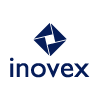

Find more notebooks like this in our central repository (LINK).

For in-depth article have a look at our [blog](https://www.inovex.de/blog).

Shared with 💙 by [inovex.de](https://www.inovex.de).